In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from feature_engineering import discretization as dc

# Дискретизация

**Определение:** *Дискретизация* - это процесс преобразования непрерывных переменных в дискретные переменные путем создания набора непрерывных интервалов, охватывающих диапазон значений переменной.

### Зачем важна дискретизация

- **Помогает улучшить производительность модели** путем группировки похожих признаков с схожей предсказательной силой.
- **Вводит нелинейность и, таким образом, улучшает способность модели к подгонке данных.**
- **Повышает интерпретируемость сгруппированными значениями.**
- **Минимизирует воздействие экстремальных значений и редко встречающихся обратных паттернов.**
- **Предотвращает возможное переобучение с числовыми переменными.**
- **Позволяет взаимодействию признаков между непрерывными переменными.**


## Загрузка данных

In [2]:
use_cols = [
    'Pclass', 'Sex', 'Age', 'Fare', 'SibSp',
    'Survived'
]

data = pd.read_csv('./data/titanic.csv', usecols=use_cols)


In [3]:
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250


In [4]:
# Здесь используем целевую переменную X_train для удобства дискретизации
X_train, X_test, y_train, y_test = train_test_split(data, data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 6), (268, 6))

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

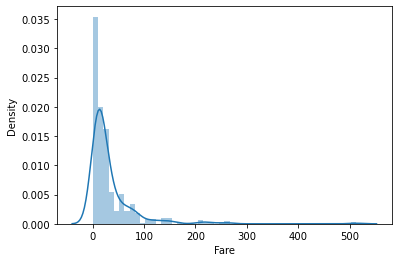

In [5]:
# длинный хвост распределения
sns.distplot(X_train['Fare'])

## Биннинг одинаковой ширины

Делим данные на N фиксированных бинов, одинаковой ширины

In [6]:
from sklearn.preprocessing import KBinsDiscretizer
enc_equal_width = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='uniform').fit(X_train[['Fare']])

In [7]:
# видим одинаковый размер для каждого бина
enc_equal_width.bin_edges_

array([array([  0.    , 170.7764, 341.5528, 512.3292])], dtype=object)

In [8]:
result = enc_equal_width.transform(X_train[['Fare']])
pd.DataFrame(result)[0].value_counts()

0.0    610
1.0     11
2.0      2
Name: 0, dtype: int64

In [9]:
# добавляем новый признак
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_equal_width'] = enc_equal_width.transform(X_train[['Fare']])
print(X_train_copy.head(10))

     Survived  Pclass     Sex   Age  SibSp      Fare  Fare_equal_width
857         1       1    male  51.0      0   26.5500               0.0
52          1       1  female  49.0      1   76.7292               0.0
386         0       3    male   1.0      5   46.9000               0.0
124         0       1    male  54.0      0   77.2875               0.0
578         0       3  female   NaN      1   14.4583               0.0
549         1       2    male   8.0      1   36.7500               0.0
118         0       1    male  24.0      0  247.5208               1.0
12          0       3    male  20.0      0    8.0500               0.0
157         0       3    male  30.0      0    8.0500               0.0
127         1       3    male  24.0      0    7.1417               0.0


## Биннинг по частотности

Деление на N бинов, где в каждом бине одинаковое количество объектов

In [10]:
enc_equal_freq = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='quantile').fit(X_train[['Fare']])

In [11]:
# Оценка границ бинов
enc_equal_freq.bin_edges_

array([array([  0.        ,   8.69303333,  26.2875    , 512.3292    ])],
      dtype=object)

In [12]:
# одинаковое число объектов в каждом бине
result = enc_equal_freq.transform(X_train[['Fare']])
pd.DataFrame(result)[0].value_counts()

2.0    209
0.0    208
1.0    206
Name: 0, dtype: int64

In [13]:
# добавляем новый признак
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_equal_freq'] = enc_equal_freq.transform(X_train[['Fare']])
print(X_train_copy.head(10))

     Survived  Pclass     Sex   Age  SibSp      Fare  Fare_equal_freq
857         1       1    male  51.0      0   26.5500              2.0
52          1       1  female  49.0      1   76.7292              2.0
386         0       3    male   1.0      5   46.9000              2.0
124         0       1    male  54.0      0   77.2875              2.0
578         0       3  female   NaN      1   14.4583              1.0
549         1       2    male   8.0      1   36.7500              2.0
118         0       1    male  24.0      0  247.5208              2.0
12          0       3    male  20.0      0    8.0500              0.0
157         0       3    male  30.0      0    8.0500              0.0
127         1       3    male  24.0      0    7.1417              0.0


## K-means биннинг

использование k-means алгоритма для деления в кластеры объектов

In [14]:
enc_kmeans = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='kmeans').fit(X_train[['Fare']])

In [15]:
# check the bin edges
enc_kmeans.bin_edges_

array([array([  0.        ,  93.5271531 , 338.08506324, 512.3292    ])],
      dtype=object)

In [16]:
result = enc_kmeans.transform(X_train[['Fare']])
pd.DataFrame(result)[0].value_counts()

0.0    587
1.0     34
2.0      2
Name: 0, dtype: int64

In [17]:
# добавляем новый признак
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_kmeans'] = enc_kmeans.transform(X_train[['Fare']])
print(X_train_copy.head(10))

     Survived  Pclass     Sex   Age  SibSp      Fare  Fare_kmeans
857         1       1    male  51.0      0   26.5500          0.0
52          1       1  female  49.0      1   76.7292          0.0
386         0       3    male   1.0      5   46.9000          0.0
124         0       1    male  54.0      0   77.2875          0.0
578         0       3  female   NaN      1   14.4583          0.0
549         1       2    male   8.0      1   36.7500          0.0
118         0       1    male  24.0      0  247.5208          1.0
12          0       3    male  20.0      0    8.0500          0.0
157         0       3    male  30.0      0    8.0500          0.0
127         1       3    male  24.0      0    7.1417          0.0


## Дискретизация с решающим деревом

использование решающего дерева для определения ключевых точек разбиения и последующей дискретизации

In [18]:
enc1 = dc.DiscretizeByDecisionTree(col='Fare',max_depth=2).fit(X=X_train,y=y_train)

In [19]:
enc1.tree_model

DecisionTreeClassifier(max_depth=2)

In [20]:
data1 = enc1.transform(data)

In [21]:
# значения признака - вероятности решающего дерева принять данный класс для объекта
print(data1.head(5))

# the unique value of the discretisized column
print(data1.Fare_tree_discret.unique())

   Survived  Pclass     Sex   Age  SibSp     Fare  Fare_tree_discret
0         0       3    male  22.0      1   7.2500           0.107143
1         1       1  female  38.0      1  71.2833           0.442308
2         1       3  female  26.0      0   7.9250           0.255319
3         1       1  female  35.0      1  53.1000           0.442308
4         0       3    male  35.0      0   8.0500           0.255319
[0.10714286 0.44230769 0.25531915 0.74626866]


In [22]:
# у нас 2 класса, глубина дерева 2 -> всего 2^2 = 4 бина

# в листьях дерева метка классов

# группировка по вероятностям отношения к данному классу
col='Fare'
bins = pd.concat([data1.groupby([col+'_tree_discret'])[col].min(),
                  data1.groupby([col+'_tree_discret'])[col].max()], axis=1)
print(bins)

# заменяем каждое значение от 0 до 7.5208 на 0.107143 и так далее

                      Fare      Fare
Fare_tree_discret                   
0.107143            0.0000    7.5208
0.255319            7.5500   10.5167
0.442308           11.1333   73.5000
0.746269           75.2500  512.3292


## Дискретизация с решающим деревом с оптимальной глубиной дерева 

In [23]:
# поиск лучшей глубины с кросс-валидацией и оценкой roc-auc
enc2 = dc.DiscretizeByDecisionTree(col='Fare',max_depth=[2,3,4,5,6,7]).fit(X=X_train,y=y_train)

In [24]:
# using optimal depth=2 we train the model, same result as last one
enc2.tree_model

DecisionTreeClassifier(max_depth=array([2]))

In [25]:
data2 = enc2.transform(data)
data2.head(5)

,Survived,Pclass,Sex,Age,SibSp,Fare,Fare_tree_discret
0,0,3,male,22.0,1,7.2500,0.107143
1,1,1,female,38.0,1,71.2833,0.442308
2,1,3,female,26.0,0,7.9250,0.255319
3,1,1,female,35.0,1,53.1000,0.442308
4,0,3,male,35.0,0,8.0500,0.255319


## ChiMerge дискретизация

Иерархическая оценка снизу-вверх интервалов на возможность их объединения c помощью целевой переменной

In [26]:
enc3 = dc.ChiMerge(col='Fare',num_of_bins=5).fit(X=X_train,y='Survived')

Интервалы для переменной Fare
  variable       interval  flag_0  flag_1
0     Fare     -inf,7.875    94.0    28.0
1     Fare   7.875,7.8792     0.0     3.0
2     Fare  7.8792,7.8958    25.0     1.0
3     Fare    7.8958,73.5   245.0   160.0
4     Fare          73.5+    17.0    50.0


In [27]:
# the bins boundary created by ChiMerge

enc3.bins

[-0.1, 7.875, 7.8792, 7.8958, 73.5, 512.3292]

In [28]:
data3 = enc3.transform(data)

In [29]:
print(data3.head(5))

   Survived  Pclass     Sex   Age  SibSp     Fare    Fare_chimerge
0         0       3    male  22.0      1   7.2500  (-0.101, 7.875]
1         1       1  female  38.0      1  71.2833    (7.896, 73.5]
2         1       3  female  26.0      0   7.9250    (7.896, 73.5]
3         1       1  female  35.0      1  53.1000    (7.896, 73.5]
4         0       3    male  35.0      0   8.0500    (7.896, 73.5]


In [30]:
# данные сгрупированы в 5 интервалов
data3.Fare_chimerge.unique()

[(-0.101, 7.875], (7.896, 73.5], (73.5, 512.329], (7.875, 7.879], (7.879, 7.896]]
Categories (5, interval[float64, right]): [(-0.101, 7.875] < (7.875, 7.879] < (7.879, 7.896] < (7.896, 73.5] < (73.5, 512.329]]